### Demo Linear
This notebook contains the steps to reproduce the experiment results of ***fair linear regression with binary sensitive attributes***.

#### Step 1: Include Packages and Set Up Global Parameters 

In [ ]:
import numpy as np
import pandas as pd
import data_parser as parser
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from fair_reg import MP_Fair_regression, MP_Penalty_regression, Fair_kernel_learning
from utils import subsample, train_test_split_groups, fix_random, SMD, gen_idx, generate_data, record_results

# Global Variables
TEST_SIZE = 0.2  # fraction of observations from each protected group
DATA_SPLIT_SEED = 4
RANDOM_SEED = 0
fix_random(RANDOM_SEED)

#### Step 2: Experiment Setting
Here we only consider linear regression with single binary sensitive attribute. 

The following four hyper-parameters are needed (See Section 2.1 for more details):
* $m$:  number of dimensions for protected attributes, e.g., 1 for signle attribute like {gender}, 2 for two attributes like {gender, race}
* $k$:  number of possible values in protected attributes (the cardinality of $\Omega_S$)
* kernel_xs: $\kappa_{XS}$, the kernel for regression
* kernel_s: $\kappa_S$, the kernel for the sensitive attributes

For linear regression with single binary sensitive attribute, we set

In [ ]:
m = 1 
k = 2 
kernel_xs = sklearn.metrics.pairwise.linear_kernel
# For kappa_s, polynomial_kernel with degree k is recommended.
kernel_s = lambda X, Y: sklearn.metrics.pairwise.polynomial_kernel(X, Y, degree=k, gamma=None, coef0=1) 

#### Step 3: Run Experiment for Each Dataset

In [ ]:
datasets = ['Synthetic', 'Adult', 'Law_school', 'Communities']
n_trail = 10 # Number of trails for each experiment

## Create a dataframe for recording the experiment results
df = pd.DataFrame(columns=['Model', 'Dataset', 'Mode', 'MSE', 'SMD'])
    
for dataset in datasets:
    for DATA_SPLIT_SEED  in range(n_trail):
        ############################################################
        ################    Data Preprocessing   ###################
        ############################################################
     
        ## Default parameters
        _SMALL = False  # small scale dataset for speed and testing
        # Assume that each sensitive attribute has values {s_0, s_1}
        s_0 = 0 
        s_1 = 1 

        # Load data
        if dataset == 'Law_school':
            x, s, y = parser.clean_lawschool_full()
            s_idx=x.columns.get_loc(s.name)
            _SMALL = True  # small scale dataset for speed and testing
            size = 1000
        elif dataset == 'Communities':
            # Race in [0,1] as protected attribute.
            x, s, y = parser.clean_communities_full()
            s_idx = x.shape[1]-1
        elif dataset == 'Adult':
            # Logistical Regression
            x, s, y = parser.clean_adult_full()
            s_idx = x.columns.get_loc(s.name)
            _SMALL = True  # small scale dataset for speed and testing
            size = 2000
        elif dataset == 'Synthetic':
            d = 5
            n = 1000
            pri_v = 0.1
            s_0 = - pri_v
            s_1 = pri_v
            f = lambda x : x
            noise = 0.1
            _, x_all, y_all = generate_data(d, n, pri_v, f, noise)

        # Subsample if needed
        if _SMALL:
            # Warning: It's possible that the subsamples don't have enough observations
            x, s, y = subsample(x, s, y, size)
        
        ## Train/test split
        if dataset == 'Synthetic':
            x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=DATA_SPLIT_SEED)
            s_train = x_train[:, d-1]
            s_test = x_test[:, d-1]
        else:
            x_train, s_train, y_train, x_test, s_test, y_test = train_test_split_groups(
                x, s, y, random_seed=DATA_SPLIT_SEED)
        
        ## Convert to numpy array
        x = np.array(x_train)
        s = np.array(s_train).reshape([-1, 1])
        y = np.array(y_train).reshape([-1, 1])

        x_val = np.array(x_test)
        s_val = np.array(s_test).reshape([-1, 1])
        y_val = np.array(y_test).reshape([-1, 1])
        
        # Centeralized
        y_mean = np.mean(y)
        y = y - y_mean
        y_val = y_val - y_mean
        
        # Add intercept column
        x = np.c_[x, np.ones_like(y)]
        x_val = np.c_[x_val, np.ones_like(y_val)]
        
        ### Generate indicators for each sensitive group.
        ### NOTE: We assume that each attribute has only binary value, i.e. 0 or 1. 
        ### If your data has other values, you should generate the indicator for each sensitive group by yourself.
        
        # Train Set
        idx_set = gen_idx(s, num_sens = m, s_0 = s_0, s_1 = s_1)

        # Testing Set
        vidx_set = gen_idx(s_val, num_sens = m, s_0 = s_0, s_1 = s_1)

        ############################################################
        ################    Experiments        #####################
        ############################################################
        
        ############### Baseline: Constant Prediction ##################
        y_pred = np.mean(y)*np.ones_like(y)
        y_val_pred = np.mean(y)*np.ones_like(y_val)

        record_results(df, 'Constant', dataset, y, y_pred, idx_set, y_val, y_val_pred, vidx_set, DATA_SPLIT_SEED)

        ############### Baseline: Ordinary Least Square ##################
        OLS_regressor = LinearRegression(fit_intercept=False)
        OLS_regressor.fit(x, y)
        y_pred = OLS_regressor.predict(x)
        y_val_pred = OLS_regressor.predict(x_val)
        
        ## Caveat: OLS may encounter numerical instability and result in a very large output. 
        ## Here we use clip to avoid such case.
        y_pred = y_pred.clip(-2, 2)
        y_val_pred = y_val_pred.clip(-2, 2)
        record_results(df, 'OLS', dataset, y, y_pred, idx_set, y_val, y_val_pred, vidx_set, DATA_SPLIT_SEED)

        ############### Baseline: Fair Kernel Learning 1000 ##################
        FKR_regressor = Fair_kernel_learning(x, s, y, eta=1000, kernel_xs=kernel_xs)
        w_ = FKR_regressor.fit()
        y_pred = FKR_regressor.pred(x)
        y_val_pred = FKR_regressor.pred(x_val)
        record_results(df, 'FKR-1000', dataset, y, y_pred, idx_set, y_val, y_val_pred, vidx_set, DATA_SPLIT_SEED)
        
        ############### Baseline: MP Fair Penalty Learning 1000 ##################
        MPP_regressor = MP_Penalty_regression(x, s, y, eta=1000, kernel_xs=kernel_xs, kernel_s = kernel_s)
        w_ = MPP_regressor.fit()
        y_pred = MPP_regressor.pred(x)
        y_val_pred = MPP_regressor.pred(x_val)
        record_results(df, 'FPR-1000', dataset, y, y_pred, idx_set, y_val, y_val_pred, vidx_set, DATA_SPLIT_SEED)

        ############### Ours: MP Fair Regression ##################
        MP_fair_regressor = MP_Fair_regression(x, s, y, kernel_xs, kernel_s, lmd = 0)
        w_ = MP_fair_regressor.fit()
        y_pred = MP_fair_regressor.pred(x)
        y_val_pred = MP_fair_regressor.pred(x_val)
        record_results(df, 'Ours', dataset, y, y_pred, idx_set, y_val, y_val_pred, vidx_set, DATA_SPLIT_SEED)


#### Step 4: Visualize the Experiment Results
* Note that due to numerical issues, the SMD of our method is almost zero (less than 1e-8 at most times) but it's still a little bit larger than the constant baseline which has a perfectly 0 disparity.

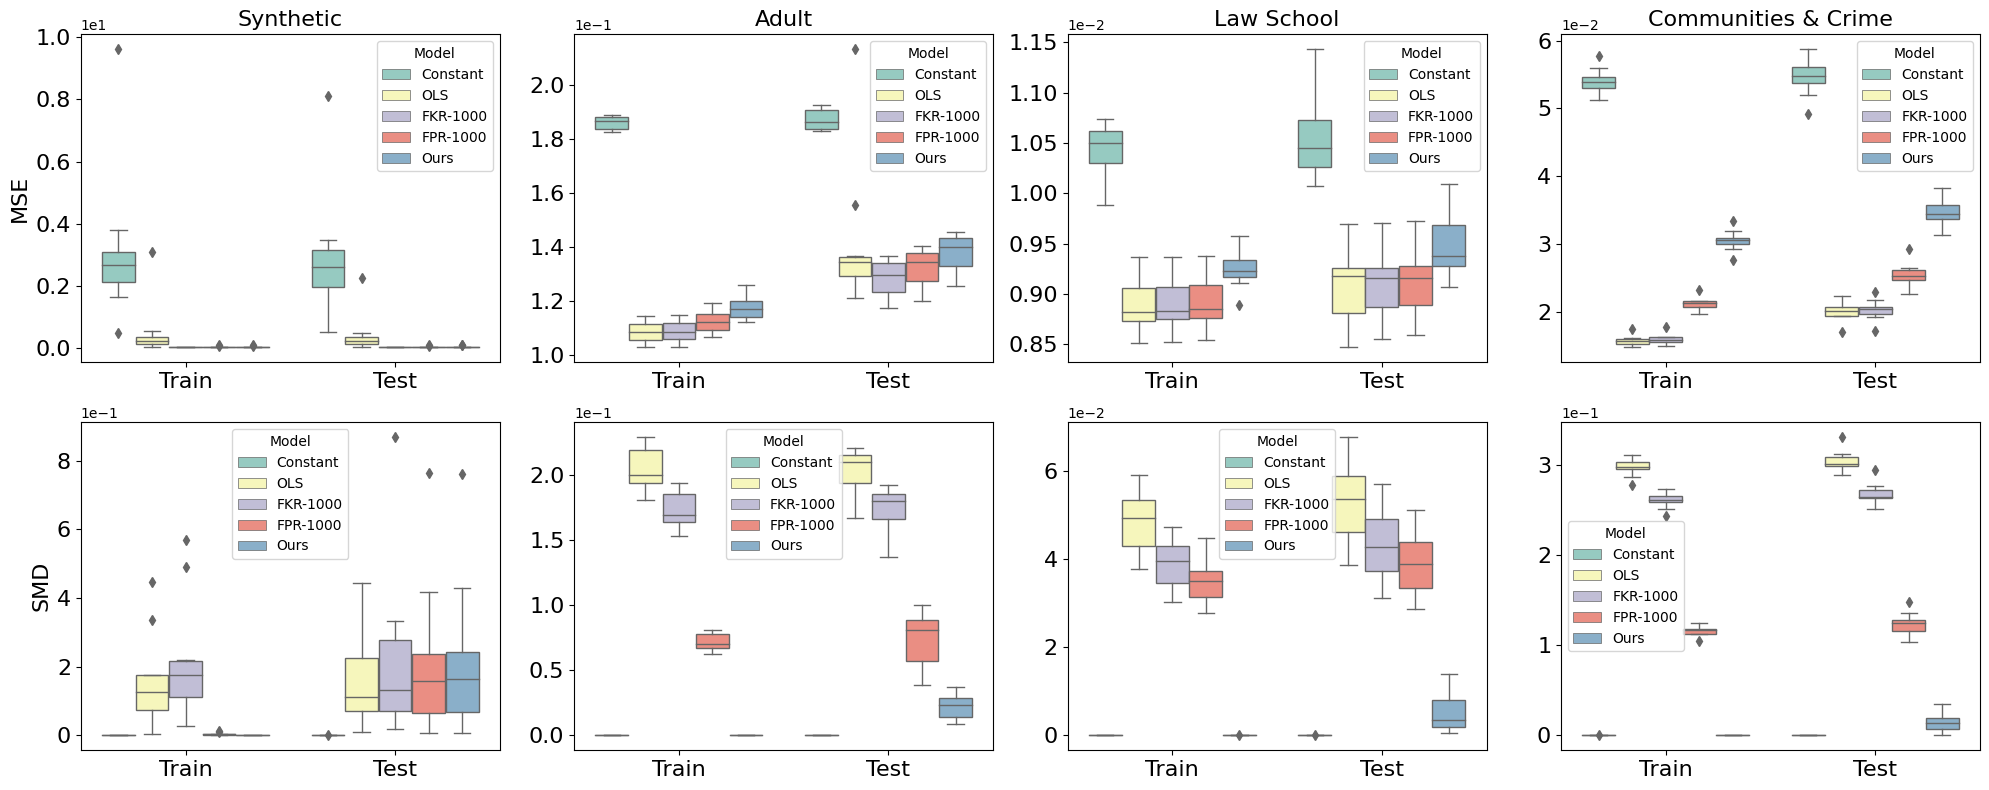

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
datasets=['Synthetic','Adult', 'Law_school', 'Communities']
for i  in range(len(datasets)):
    ax = sns.boxplot(ax=axes[0,i], x="Mode", y="MSE", hue="Model",
             data=df[df.Dataset==datasets[i]], palette="Set3",linewidth=1)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=16)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax = sns.boxplot(ax=axes[1,i], x="Mode", y="SMD", hue="Model",
             data=df[df.Dataset==datasets[i]], palette="Set3",linewidth=1)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=16)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,-1))
axes[0,0].set_ylabel('MSE', fontsize=16)
axes[1,0].set_ylabel('SMD',fontsize=16)
axes[0,0].set_title('Synthetic',fontsize=16)
axes[0,1].set_title('Adult',fontsize=16)
axes[0,2].set_title('Law School',fontsize=16)
axes[0,3].set_title('Communities & Crime',fontsize=16)
plt.tight_layout()

